In [128]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# visualization
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# LDA
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, Word2Vec

# BERTopic
from bertopic import BERTopic
from transformers import BertTokenizer, BertModel

# Text Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import pickle

#evaluation
from collections import Counter
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [129]:
df = pd.read_csv('D:/Coding/school/thesis dhewa/preprocessing/export/processed_df.csv', header=None)
df_tokenized = pd.read_csv('D:/Coding/school/thesis dhewa/preprocessing/export/tokenized_processed_df.csv', header=None)

In [130]:
df

,0
0,mentok melulu di pin tiap mau log in tidak bis...
1,baru mau coba kalau bangus ya tidak kasih 5
2,loading splash screennya lama harus restart ha...
3,rubbish
4,sok many rules sok difficult for sharing
...,...
310,kenapa harus di baru
311,tiap saat baru bagus yang awal lebih nnyaman
312,baru coba
313,tidak bisa di instal


In [131]:
df_tokenized

,0
0,"['mentok', 'melulu', 'di', 'pin', 'tiap', 'mau..."
1,"['baru', 'mau', 'coba', 'kalau', 'bangus', 'ya..."
2,"['loading', 'splash', 'screennya', 'lama', 'ha..."
3,['rubbish']
4,"['sok', 'many', 'rules', 'sok', 'difficult', '..."
...,...
311,"['kenapa', 'harus', 'di', 'baru']"
312,"['tiap', 'saat', 'baru', 'bagus', 'yang', 'awa..."
313,"['baru', 'coba']"
314,"['tidak', 'bisa', 'di', 'instal']"


# Autoencoder

## Vectorize

In [133]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_tokenized[0].astype(str)).toarray()

In [134]:
# Train Word2Vec model
w2v_model = Word2Vec(sentences=df_tokenized, vector_size=100, min_count=1, workers=4)

# Convert each sentence into the mean of word embeddings
X = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) 
              for words in df_tokenized])

TypeError: 'int' object is not iterable

## Train the Autoencoder

In [135]:
class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        if X.shape[0] > 1:  # Only split if more than 1 sample
            X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
        else:
            X_train, X_test = X, X
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [136]:
autoencoder = Autoencoder(latent_dim=32, activation='relu', epochs=200, batch_size=128)

autoencoder.fit(X)

In [137]:
encoded_data = autoencoder.encoder.predict(X)  
decoded_data = autoencoder.autoencoder.predict(X)

# Convert encoded features to DataFrame and save
encoded_df = pd.DataFrame(encoded_data)
encoded_df

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.537204,0.053877,0.001101,0.396960,0.386924,0.182244,0.082189,0.489979,0.159891,0.152859,...,0.324867,0.417502,0.622242,0.419534,0.621012,0.438682,0.213139,0.292487,0.250172,0.246400
1,0.669121,0.543171,0.300479,0.393001,0.115988,0.407909,0.150364,0.452380,0.125904,0.264071,...,0.077088,0.148124,0.253717,0.247752,0.148616,0.022589,0.041357,0.038681,0.721292,0.207949
2,0.187404,0.000099,0.392750,0.574332,0.447473,0.494877,0.319859,0.677080,0.037666,0.075415,...,0.057053,0.128555,0.399402,0.102414,0.174800,0.417725,0.231264,0.212961,0.399476,0.224776
3,0.180382,0.264381,0.166740,0.139742,0.159556,0.272633,0.192821,0.163400,0.304259,0.293347,...,0.167655,0.197175,0.152349,0.218859,0.167555,0.176374,0.183004,0.241418,0.242585,0.120879
4,0.340739,0.000000,0.323924,0.000067,0.176628,0.319353,0.442921,0.086965,0.457069,0.124676,...,0.228195,0.190104,0.450440,0.226046,0.098967,0.120246,0.329512,0.259616,0.216808,0.282854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,0.012474,0.163803,0.122629,0.114797,0.091627,0.170772,0.281176,0.534045,0.575230,0.102808,...,0.435535,0.297892,0.176417,0.462835,0.321369,0.433112,0.126718,0.437206,0.558725,0.280461
312,0.506862,0.177186,0.198079,0.205355,0.137394,0.409834,0.000000,0.255618,0.489591,0.024950,...,0.007761,0.083510,0.137970,0.596119,0.332419,0.471735,0.125312,0.311281,0.382397,0.145369
313,0.526021,0.223234,0.420979,0.385762,0.000165,0.186446,0.068127,0.479524,0.328974,0.125982,...,0.009754,0.006102,0.128333,0.196776,0.062304,0.104981,0.115408,0.251095,0.565859,0.000000
314,0.243238,0.048798,0.164541,0.184568,0.055284,0.294331,0.143481,0.140503,0.394645,0.382205,...,0.549566,0.643964,0.187214,0.558247,0.605642,0.373804,0.620977,0.452922,0.572914,0.075801


# Model

## Define Model

In [138]:
class Topic_Model:
    def __init__(self, k=10, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

In [139]:
tm = Topic_Model(k=10, method="LDA_BERT")

## Apply Model

In [140]:
df = df.dropna(subset=[0])  # Remove NaN
df = df[df[0].str.strip() != ""]  # Remove empty strings

In [141]:
df_tokenized = df_tokenized.loc[df.index]

In [142]:
import ast

sentences = df[0].tolist()  
token_lists = df_tokenized[0].apply(ast.literal_eval).tolist()

In [143]:
tm.fit(sentences, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!


# Evaluation

In [144]:
def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/kaggle/working/contextual_topic_identification/docs/images/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working/2D_vis')

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    if model.method == 'LDA':
        return
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(token_lists[i]) for i in range(len(token_lists)) if lbs[i] == topic])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/kaggle/working/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))

In [151]:
def find_best_ntopic(sentences, token_lists, method="LDA_BERT", ntopic_range=(3, 8)):
    best_ntopic = None
    best_coherence = float("-inf")
    
    for ntopic in range(ntopic_range[0], ntopic_range[1] + 1):  # Try different ntopic values
        tm = Topic_Model(k=ntopic, method=method)
        tm.fit(sentences, token_lists)
        coherence = get_coherence(tm, token_lists, 'c_v')
        
        print(f"ntopic={ntopic}, Coherence={coherence}")  # Log coherence scores
        
        if coherence > best_coherence:
            best_coherence = coherence
            best_ntopic = ntopic
    
    return best_ntopic, best_coherence

def main():
    method = "LDA_BERT"
    samp_size = 51000

    # Find best ntopic based on coherence score
    best_ntopic, best_coherence = find_best_ntopic(sentences, token_lists)

    print(f"Best ntopic: {best_ntopic} with Coherence: {best_coherence}")

    # Train final model with best ntopic
    tm = Topic_Model(k=best_ntopic, method=method)
    tm.fit(sentences, token_lists)

    # Save model
    with open(f"D:/Coding/school/thesis dhewa/modeling/model/{tm.id}.file", "wb") as f:
        pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

    print('Final Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))

    # Visualization
    visualize(tm)
    for i in range(tm.k):
        get_wordcloud(tm, token_lists, i)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!
ntopic=3, Coherence=0.7086000384160908
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!
ntopic=4, Coherence=0.5004542284336101
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Clustering embeddings. Done!
ntopic=5, Coherence=0.677524080829228
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Clustering embeddings. Done!
ntopic=6, Coherence=0.5772558180387618
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!
ntopic=7, Coherence=0.5716448082161183
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!
ntopic=8, Coherence=0.6175747928787787
Best ntopic: 3 with Coherence: 0.7086000384160908
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!
Final Coherence: 0.6975642350402674
Silhouette Score: 0.65584075
Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!


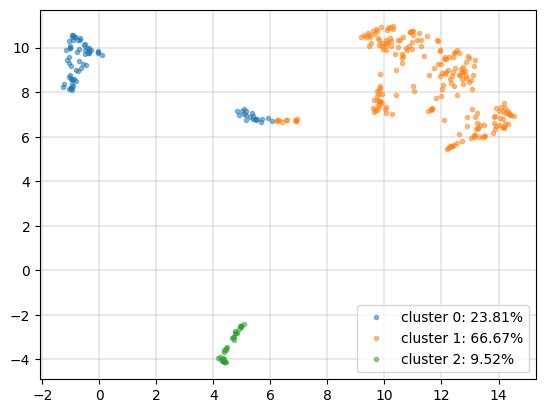

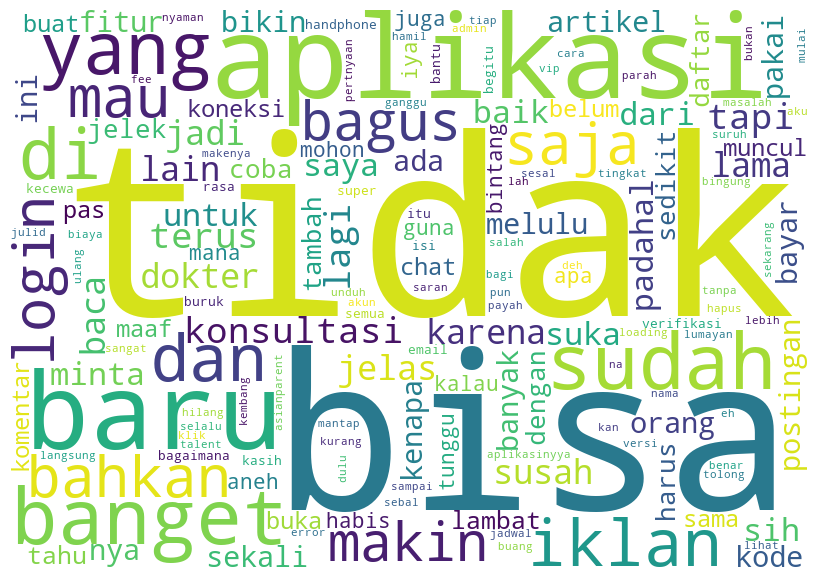

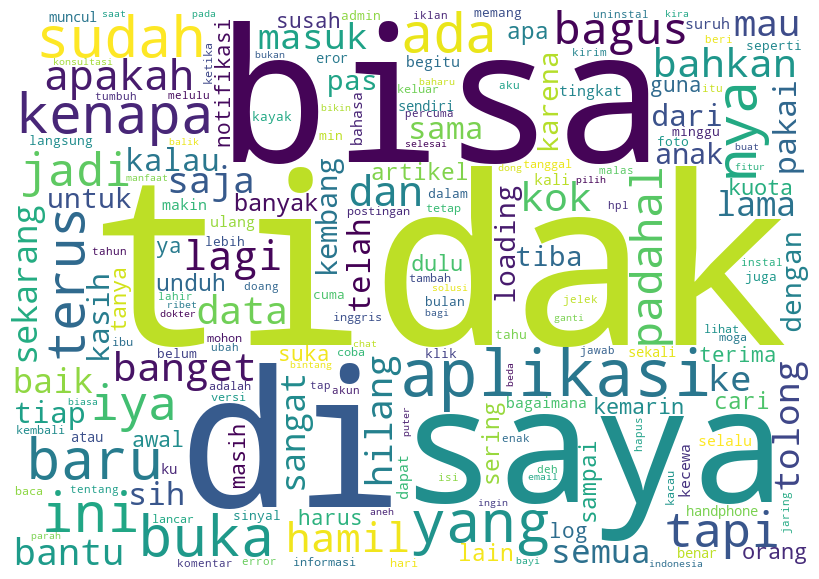

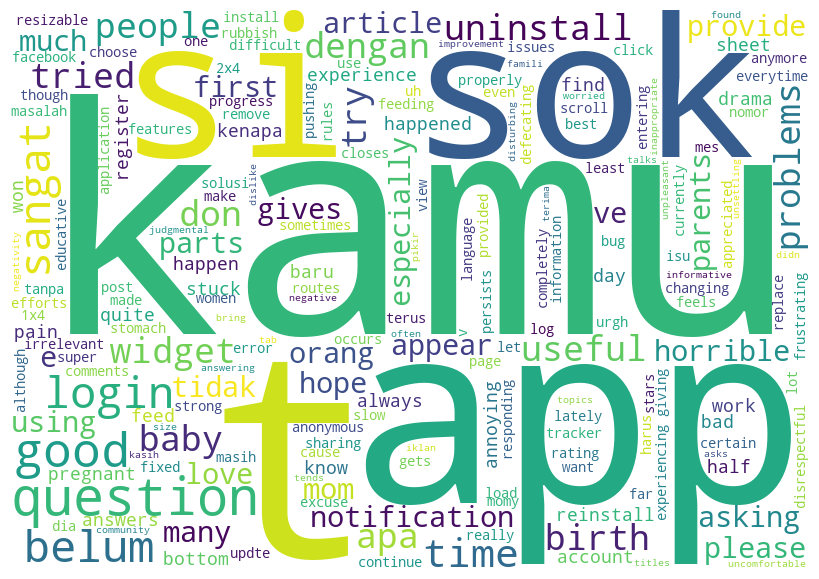

In [152]:
main()

# Visualize Result

In [158]:
tm = Topic_Model(k=3, method="LDA_BERT")  # Re-train with best topic count
tm.fit(sentences, token_lists)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Clustering embeddings. Done!


In [159]:
def print_top_words(model, token_lists):
    """
    Print top words for each topic
    """
    topics = get_topic_words(token_lists, model.cluster_model.labels_)
    for i, words in enumerate(topics):
        print(f"\n🔹 Topic {i}: {', '.join(words)}")

In [160]:
print_top_words(tm, token_lists)



🔹 Topic 0: tidak, bisa, di, aplikasi, saya, buka, kenapa, sudah, terus, ada

🔹 Topic 1: tidak, baru, yang, di, bagus, dan, aplikasi, nya, saya, sudah

🔹 Topic 2: the, to, i, it, for, not, kamu, sangat, and, t


In [161]:
df["topic"] = [f"Topic {label}" for label in tm.cluster_model.labels_]

In [162]:
df

,0,topic
0,mentok melulu di pin tiap mau log in tidak bis...,Topic 0
1,baru mau coba kalau bangus ya tidak kasih 5,Topic 1
2,loading splash screennya lama harus restart ha...,Topic 0
3,rubbish,Topic 0
4,sok many rules sok difficult for sharing,Topic 2
...,...,...
310,kenapa harus di baru,Topic 1
311,tiap saat baru bagus yang awal lebih nnyaman,Topic 0
312,baru coba,Topic 1
313,tidak bisa di instal,Topic 1
